# Suavização e Alisamento exponencial

por **Cibele Russo**

Baseado em 

- Moretting, P.A.; Toloi, C.M.C. “Análise de Séries Temporais”. Blucher, 2004.
- Ehlers, R.S. (2009) Análise de Séries Temporais, [http://www.icmc.usp.br/~ehlers/stemp/stemp.pdf](http://www.icmc.usp.br/~ehlers/stemp/stemp.pdf). Acessado em 28/06/2020.





## Suavização

- A suavização permite que a tendência da série em um instante t possa ser estimada usando-se observações $Z_s$ com $s$ ao redor de $t$, por exemplo, usando as observações $Z_{t-n},Z_{t-n+1},\ldots, Z_{t+n}$ para estimar $T_t$.

- Procedimentos não paramétricos para aproximar localmente a série

- Transformação da série $Z_t$ em uma série $Z_t^{\star}$

Considere que as observações da série temporal $\{Z_t\}$ possam ser localmente decompostas em seu nível e mais um ruído aleatório 

$$Z_t = \mu_t + a_t, \mbox{ para } t=1,\ldots, N$$

com $E(a_t)=0$ e $Var(a_t) = \sigma^2$ e $\mu_t$ é um parâmetro desconhecido, que pode variar lentamente com o tempo e que queremos estimar.



Alguns procedimentos de suavização:

- Médias móveis

- Medianas móveis

- Lowess

- Métodos de Holt-Winters




## Média móvel simples


Dadas as observações $Z_1,\ldots,Z_N$, a média móvel é dada por

$$Z_t^{\star} = M_t = \displaystyle{\frac{Z_t+Z_{t-1}+\ldots +Z_{t-(r+1)}}{r}},$$

ou

$$Z_t^{\star} = M_t = M_{t-1} + \displaystyle{\frac{Z_t-Z_{t-r}}{r}}$$



In [1]:
# Médias móveis para dados de passageiros aéreos

import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
pkgdir = 'Pratica'

passageiros = pd.read_csv(f'{pkgdir}/airline_passengers.csv', index_col=0,
                            parse_dates=True)

# Tirar dados faltantes pois influenciariam no cálculo da média móvel

passageiros = passageiros.dropna()

# OU poderia fazer simplesmente passageiros.dropna(inplace=True)

In [3]:
passageiros.head()

,Milhares de passageiros
Mês,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121



Podemos criar uma média móvel simples usando a função mean em rolling.
[Veja a documentação do rolling do pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)




In [4]:
passageiros['MMS-6-meses'] = passageiros['Milhares de passageiros'].rolling(window=6).mean()
passageiros['MMS-12-meses'] = passageiros['Milhares de passageiros'].rolling(window=12).mean()

In [5]:
passageiros.head(15)

,Milhares de passageiros,MMS-6-meses,MMS-12-meses
Mês,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


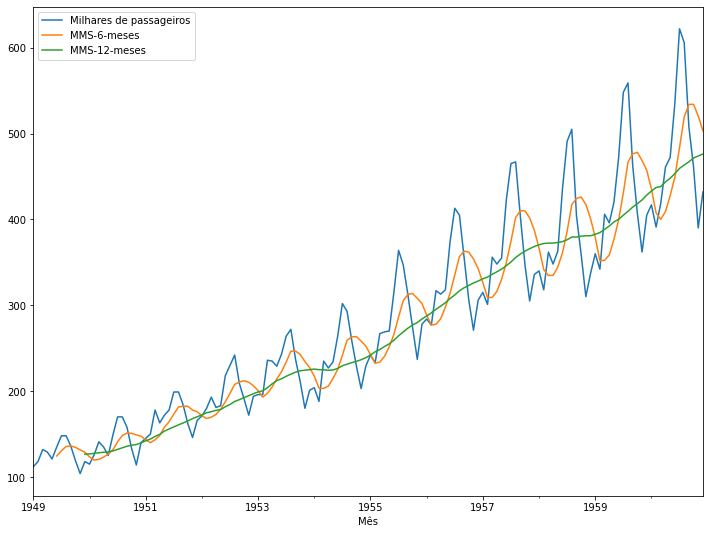

In [6]:
passageiros.plot(figsize=(12,9));

**Exercício:**

Crie um gráfico da mediana móvel. Quais as implicações?

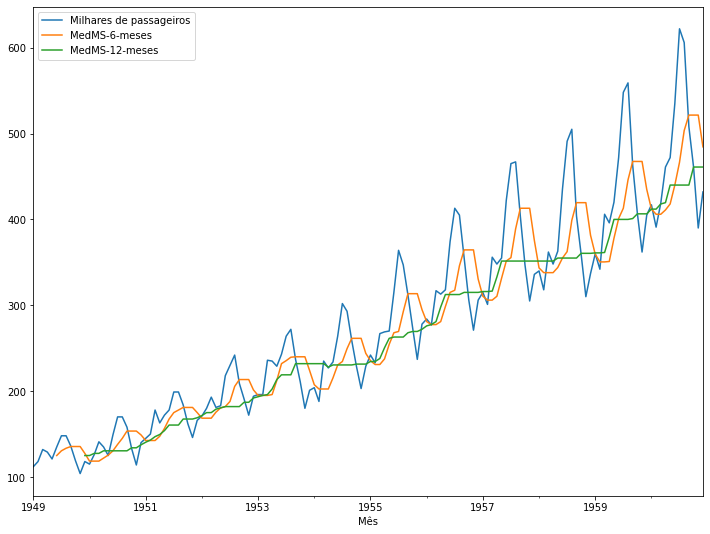

In [7]:
passageiros['MedMS-6-meses'] = passageiros['Milhares de passageiros'].rolling(window=6).median()
passageiros['MedMS-12-meses'] = passageiros['Milhares de passageiros'].rolling(window=12).median()

passageiros[['Milhares de passageiros','MedMS-6-meses','MedMS-12-meses']].plot(figsize=(12,9));

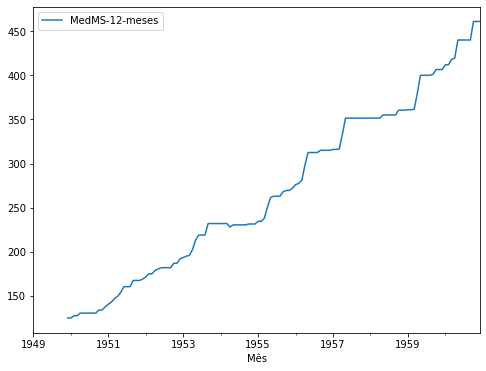

In [8]:
passageiros[['MedMS-12-meses']].plot(figsize=(8,6));

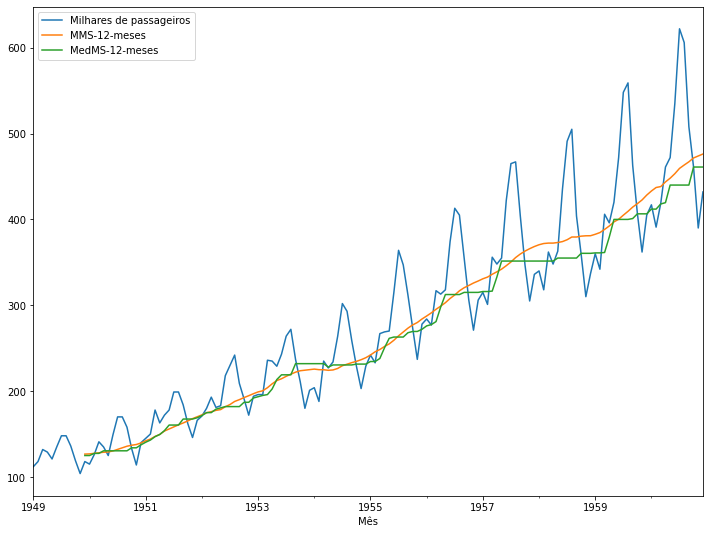

In [9]:
passageiros[['Milhares de passageiros','MMS-12-meses','MedMS-12-meses']].plot(figsize=(12,9));

## Média móvel exponencialmente ponderada  (MMEP)

As médias móveis simples têm algumas desvantagens:

- Janelas menores levarão a mais ruído, em vez de sinal
- Ele nunca alcançará o pico ou vale máximo dos dados devido ao cálculo da média.
- Não informa sobre possíveis comportamentos futuros, tudo o que realmente faz é descrever tendências em seus dados.
- Valores históricos extremos podem distorcer significativamente a MMS



Uma possível proposta para contornar esses problemas é a **média móvel exponencialmente ponderada**.

A MMEP permite reduzir o efeito de atraso da MMS e dará mais peso aos valores que ocorreram mais recentemente (aplicando mais peso aos valores mais recentes, portanto, o nome). A quantidade de peso aplicada aos valores mais recentes dependerá dos parâmetros reais usados na MMEP e do número de períodos determinados pelo tamanho da janela.


A MMEP é dada por

$$\overline{Z}_t = \alpha Z_t + (1-\alpha) Z_{t-1},$$

com $\overline{Z}_0=Z_1$;  $t=1,\ldots,N,$ e $\alpha$ é uma constante tal que $0\leq\alpha\leq 1$.
				
			

Uma representação alternativa mais geral da MMEP implementada em Python é

$\overline{Z}_t =   \frac{\sum\limits_{i=0}^{t-1} w_i Z_{t-i}}{\sum\limits_{i=0}^{t-1} w_i}$

Aqui, $Z_t$ é a entrada, $w_i$ é o peso aplicado (Note que os pesos podem ser diferentes de $i=0$ a $(t-1)$), e $\overline{Z}_t$ é a saída.

Agora a questão é, como podemos definir o peso $w_i$?

Isso pode ser feito mudando valores do parâmetro adjust no método .ewm.

Quando <tt>adjust=True</tt> (default) as médias móveis ponderadas são calculadas usando pesos iguais a $w_i = (1 - \alpha)^i$

o que nos dá

$\overline{Z}_t = \frac{Z_t + (1 - \alpha)Z_{t-1} + (1 - \alpha)^2 Z_{t-2} + \ldots
+ (1 - \alpha)^{t-1} Z_{1}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^{t-1}}$

Quando <tt>adjust=False</tt> as médias móveis são calculadas da forma

$\begin{array}{ll}\overline{Z}_0 &= Z_1 \\
\overline{Z}_t &= (1 - \alpha) Z_{t-1} + \alpha Z_t,\end{array}$

o que é equivalente a usar os pesos

$w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{se } i < t \\
    (1 - \alpha)^i        & \text{se } i = t.
\end{cases}$

Quando adjust=True nós temos $\overline{Z}_0=Z_1$ e da última representação acima nós temos
$\overline{Z}_t=\alpha Z_t+(1−α)\overline{Z}_{t−1}$, portanto existe uma suposição que $Z_1$ não é um valor ordinário mas um momento exponencialmente ponderado das séries infinitas até aquele ponto.

Para o fator de suavização $\alpha$ tem-se que $0<\alpha≤1$, e enquanto é possível passar **$\alpha$** diretamente, é frequentemente mais fácil pensar ou em **span**, **centro de massa** ou **meia vida** de um momento exponencialmente ponderado

$\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{para span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{para centro de massa}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{para meia-vida}\ h > 0
 \end{cases}$

* **Span** corresponde ao que é comumente chamado uma "média móvel exponencialmente ponderada em N dias".
* **Centro de massa** tem uma interpretação física e pode ser pensado em termos do span: $c=(s−1)/2$
* **Meia-vida** é o período de tempo para o peso exponencial se reduzir pela metade.
* **Alpha** especifica o fator de suavização diretamente.

Temos que passar precisamente um dos parâmetros acima para a função .ewm(). Usaremos span=12.

In [10]:
passageiros['MMEP12'] = passageiros['Milhares de passageiros'].ewm(span=12,adjust=False).mean()

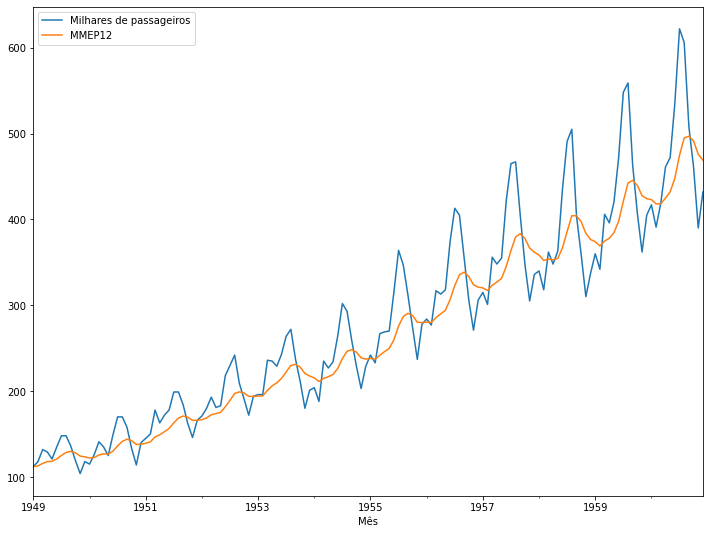

In [14]:
passageiros[['Milhares de passageiros','MMEP12']].plot(figsize=(12,9));

## Comparando MMS com MMEP

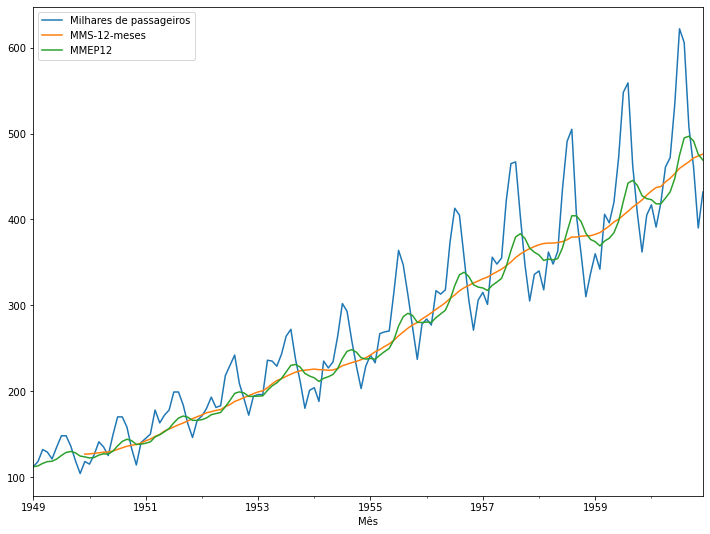

In [15]:
passageiros[['Milhares de passageiros','MMS-12-meses','MMEP12']].plot(figsize=(12,9)).autoscale(axis='x',tight=True);

**Exercício**

Aplique os métodos de média móvel (7 dias) e média exponencialmente ponderada (span=7) aos dados de mortes registradas por COVID-19 no estado de SP.


In [16]:
covidSP = pd.read_csv('covidSP.csv', index_col=0,parse_dates=True)

In [17]:
covidSP.head()

,confirmed,deaths
date,,
2020-02-26,0,0
2020-02-27,0,0
2020-02-28,1,0
2020-02-29,0,0
2020-03-01,0,0


In [18]:
covidSP['MMS-7-dias'] = covidSP['deaths'].rolling(window=7).mean()
covidSP['MMEP-7'] = covidSP['deaths'].ewm(span=7,adjust=False).mean()

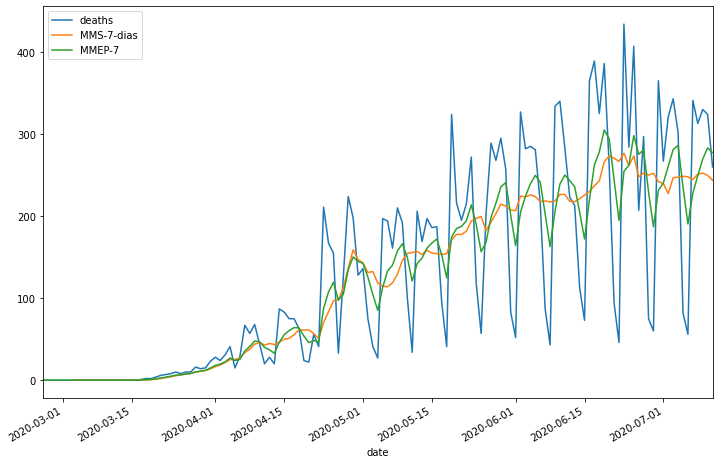

In [19]:
covidSP[['deaths','MMS-7-dias','MMEP-7']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

**Exercício**
Repita para 14 dias e span=14.
Compare esses resultados com os gráficos com 5 dias e span=5. 
Você nota alguma relação com esses parâmetros e a suavidade da curva?

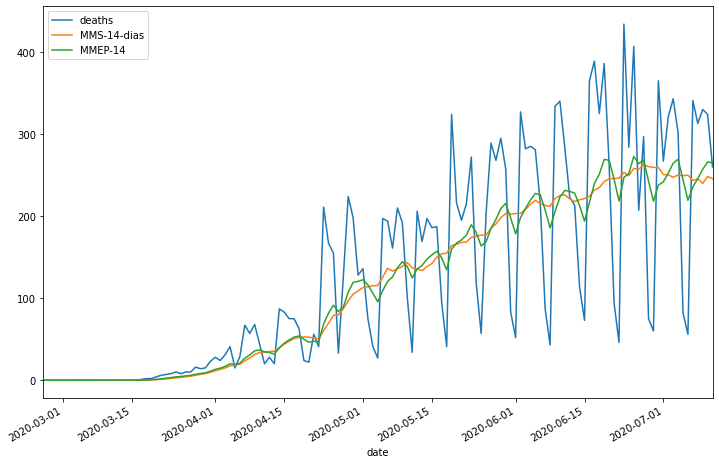

In [20]:
covidSP['MMS-14-dias'] = covidSP['deaths'].rolling(window=14).mean()
covidSP['MMEP-14'] = covidSP['deaths'].ewm(span=14,adjust=False).mean()
covidSP[['deaths','MMS-14-dias','MMEP-14']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

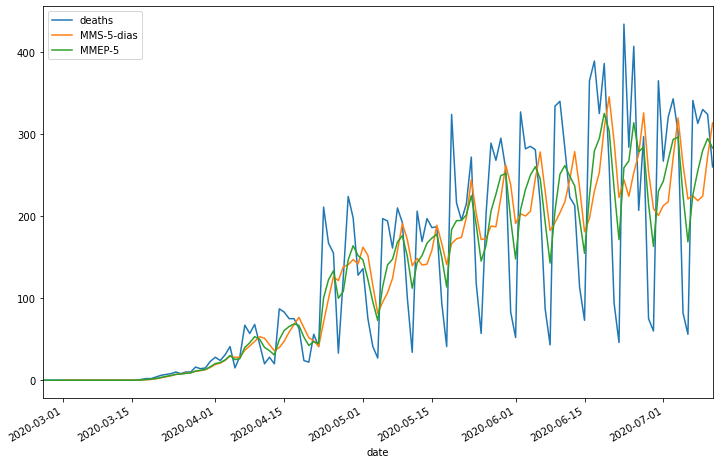

In [21]:
covidSP['MMS-5-dias'] = covidSP['deaths'].rolling(window=5).mean()
covidSP['MMEP-5'] = covidSP['deaths'].ewm(span=5,adjust=False).mean()
covidSP[['deaths','MMS-5-dias','MMEP-5']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

**Exercício**
Repita as análises para os dados de temperatura global.
Descreva a tendência indicada pela média móvel com janela de 10 dias e span=10.



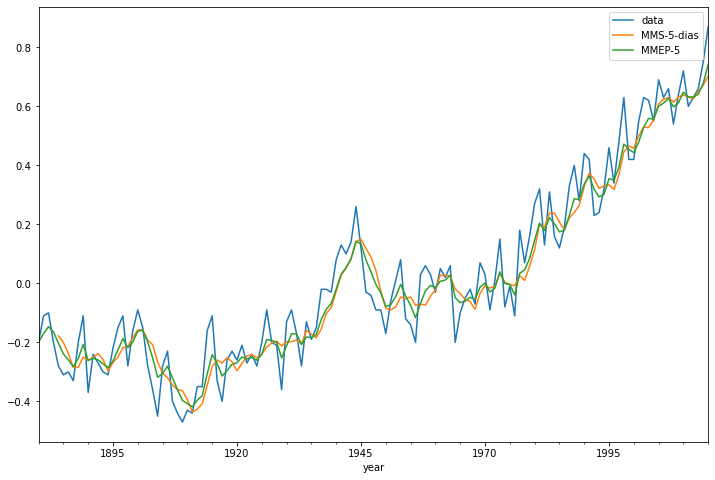

In [22]:
globaltemp = pd.read_csv(f'{pkgdir}/globaltemp.csv', index_col=0,
                         parse_dates=True)
globaltemp.index = globaltemp.index

globaltemp['MMS-5-dias'] = globaltemp['data'].rolling(window=5).mean()
globaltemp['MMEP-5'] = globaltemp['data'].ewm(span=5,adjust=False).mean()
globaltemp[['data','MMS-5-dias','MMEP-5']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

Na próxima semana daremos continuidade às técnicas de suavização com os Métodos de Suavização Holt-Winters, e falaremos também sobre estacionariedade e outros aspectos de séries temporais. Até lá!